In [158]:
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal
import itertools
from matplotlib.lines import Line2D
import matplotlib.cm as cm
from sklearn.preprocessing import minmax_scale
cmap = cm.coolwarm

# Gaussian Distribution

In [159]:
w = 50
x, y = np.meshgrid(np.linspace(-3,3,w), np.linspace(-3,3,w))
mean1 = np.array([0,0])
cov1 = np.array([[1,0],
                [0,1]])

mean2 = np.array([0,0])
cov2 = np.array([[1,.8],
                [.8,1]])

In [160]:
def find_nearest(array, value):
    idx = (np.abs(array - value)).argmin()
    return idx
    

def plot_gaussian(fig, pos, x,y, mean, cov, condX = 0, condY = 0):

    linewidths = 2
    
    gauss = multivariate_normal(mean,cov)
    
    z = np.vectorize(lambda a, b: gauss.pdf((a,b)))(x,y)
    print(x.shape, y.shape, z.shape)
    ax = fig.add_subplot(pos, projection='3d', proj_type='ortho', elev=35, azim=25, zlim3d=(-0.4,0.3), xlabel='X', ylabel='Y', zlabel='Density')
    
    # 3d density
    ax.plot_surface(x, y, z, cmap=cmap, )

    # 2d heatmap
    cset = ax.contourf(x, y, z, zdir='z', offset=-0.4, cmap=cmap)
    
    # conditionals
    gauss_cx = multivariate_normal(mean[0] + (cov[0,1]/cov[1,1])*(condX-mean[1]), cov[0,0] - (cov[0,1]*cov[1,0])/cov[1,1])
    cx = np.tile( gauss_cx.pdf(x[0,:]), (50,1))/1
    ax.contour(x, y, cx, zdir='y', offset=-3, levels=[-100, 0], colors=[cmap(0.99)], linewidths=linewidths)
    
    gauss_cy = multivariate_normal(mean[1] + (cov[1,0]/cov[0,0])*(condY-mean[0]), cov[1,1] - (cov[1,0]*cov[0,1])/cov[0,0])
    cy = np.tile( gauss_cy.pdf(y[:,0]), (50,1)).T/1
    ax.contour(x, y, cy, zdir='x', offset=-3, levels=[-100, 0], colors=[cmap(0)], linewidths=linewidths)
        
    # marginals
    gauss_mx = multivariate_normal(mean[0],cov[0,0])
    mx = np.tile( gauss_mx.pdf(x[0,:]), (50,1))/1
    cset = ax.contour(x, y, mx, zdir='y', offset=-3, levels=[0, 100], colors=['black'], linewidths=linewidths, linestyles='dotted')
    gauss_my = multivariate_normal(mean[1],cov[1,1])
    my = np.tile( gauss_mx.pdf(y[:,0]), (50,1)).T/1
    #my = np.tile(np.mean(z, axis=1), (50,1)).T/1
    cset = ax.contour(x, y, my, zdir='x', offset=-3, levels=[0, 100], colors=['black'],  linewidths=linewidths, linestyles='dotted')
    
    custom_lines = [Line2D([0], [0], color='black', lw=3, linestyle='dotted'),
                    Line2D([0], [0], color=cmap(0.99), lw=3),
                    Line2D([0], [0], color=cmap(0), lw=3)]

    ax.legend(custom_lines, ['Marginals', 'P(X | Y = %.1f)'%condY, 'P(Y | X = %.1f)'%condX])

(50, 50) (50, 50) (50, 50)
(50, 50) (50, 50) (50, 50)


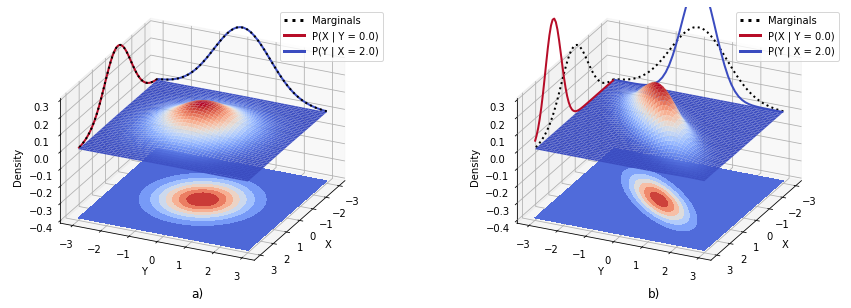

In [161]:
fig = plt.figure(figsize=(15,5))
plot_gaussian(fig, 121, x,y, mean1, cov1, condX=2, condY=0)
plot_gaussian(fig, 122, x,y, mean2, cov2, condX=2, condY=0)
fig.get_axes()[0].set_title('a)', y=-0.1)
fig.get_axes()[1].set_title('b)', y=-0.1);

# Polynomials

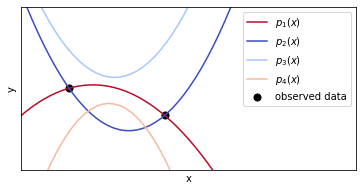

In [5]:
fig, ax = plt.subplots(1,1,figsize=(6,3))
ax.scatter([1,2],[2,1.5],s=50,c='k', label='observed data')
ax.set_xlim(0.5,4), ax.set_ylim(0.5,3.5)
ax.set_xlabel('x'); ax.set_ylabel('y')
ax.set_xticks([]); ax.set_yticks([])
x = np.linspace(0,3,50)
a = np.array([-1,2,-3])
b = -3*a-0.5
c = 2*a+5/2
ax.plot(x, a[0]*x**2 + b[0]*x + c[0], c=cmap(.99), label='$p_1(x)$')
ax.plot(x, a[1]*x**2 + b[1]*x + c[1], c=cmap(.0), label='$p_2(x)$')
ax.plot(x, 1.1*a[1]*x**2 + b[1]*x + c[1]+0.5, c=cmap(.33), label='$p_3(x)$')
ax.plot(x, a[2]*x**2 + b[2]*x + c[2]-0.8, c=cmap(.66), label='$p_4(x)$');

plt.legend();

# Gaussian Process

In [6]:
def partition(matrix, xIndices, yIndices):
    mesh = np.meshgrid(xIndices, yIndices)
    return matrix[mesh[0].ravel(), mesh[1].ravel()].reshape(mesh[0].shape)
    

def plot_gp(mean, cov, size=1, condOn=None, cond=None):
    assert (condOn is None or len(condOn) == len(cond) or isinstance(cond, str) or isinstance(cond, float)), 'condOn and cond must have same length'
    if condOn is None: cond = None
    if condOn is not None:
        assert isinstance(condOn, list) and len(condOn) > 0, 'condOn should not be an empty list - pass None instead'
        
        cond = np.asarray(cond).reshape(-1,1)

        condMask = np.zeros(len(mean), dtype=np.bool)
        condMask[condOn] = 1
        notCondOn = np.arange(len(mean))

        meanA = mean[notCondOn].reshape(-1,1)
        meanB = mean[condOn].reshape(-1,1)

        covBB = partition(cov, condOn, condOn)
        covBA = partition(cov, notCondOn, condOn)
        covAB = partition(cov, condOn, notCondOn)
        covAA = partition(cov, notCondOn, notCondOn)

        
        _mean = np.matmul(np.matmul(covAB, np.linalg.inv(covBB)), (cond-meanB)) 
        _cov = covAA - np.matmul(np.matmul(covAB, np.linalg.inv(covBB)), covBA)
    else:
        _mean = mean.reshape(-1,1)
        _cov = cov
        
    c = np.random.multivariate_normal(_mean.ravel(), _cov, size=size)
    #s = np.zeros(len(mean))
    #if cond is not None:
    #    s[condOn] = cond.ravel()
    #    s[notCondOn] = c.ravel()
    #else: 
    #    s[:] = c.ravel()
    return c.reshape(D,size), _mean.reshape(D), _cov



def plot_samples(fig, ax, mean, cov, condOn=None, cond=None, n_samples = 50, linestyle='-', conf=None):
    assert (condOn is None or len(condOn) == len(cond) or isinstance(cond, str) or isinstance(cond, float)), 'condOn and cond must have same length'
    if condOn is not None and isinstance(cond, (str, float)):
        cond = [cond]*len(condOn)
    ax[0].set_prop_cycle(color=[cm.coolwarm(i) for i in np.linspace(0,0.99,n_samples)])
    for i in np.linspace(-1,1,n_samples):
        if condOn is not None:
            _cond = [i if c == 'linear' else c for c in cond]
        else: 
            _cond = None
        s, post_mean, post_cov = plot_gp(mean, cov, condOn=condOn, cond=_cond)
        ax[0].plot(s, linestyle)
        ax[0].set_xticks(np.arange(D))
        ax[0].set_xticklabels(['$X_{%i}$'%i for i in range(D)])
        ax[0].set_ylim(-3,3)
        ax[0].vlines(condOn,-2,2)
    if not conf is None:
        ax[0].plot(np.arange(D), post_mean, '-', linewidth=3, color=[0,0,0,0.3], label='Posterior mean')
        ax[0].fill_between(np.arange(D), post_mean+conf*np.diagonal(post_cov), post_mean-conf*np.diagonal(post_cov), color=[0,0,0,0.05], label='Confidence interval')
    im = ax[1].imshow(cov, cmap=cm.coolwarm, vmin=-1, vmax=1)
    fig.colorbar(im, ax = ax[1],ticks=[-1,0,1])
    return post_mean, post_cov

### Multivariate Gaussian samples as 2D dataset

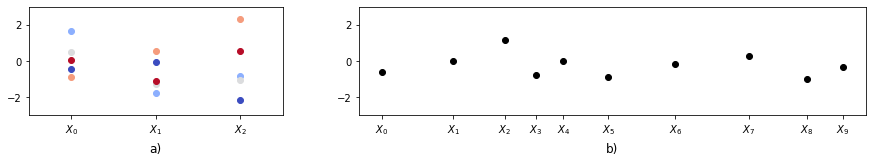

In [7]:
np.random.seed(2)
D = 3
mean = np.zeros(D)
cov = np.eye(D)
n_samples=5
   
fig, ax = plt.subplots(1,2, figsize=(15,2), gridspec_kw={'width_ratios': [1, 2]})
ax[0].set_prop_cycle(color=[cm.coolwarm(i) for i in np.linspace(0,0.99,n_samples)])
for i in range(n_samples):
    ax[0].scatter(np.arange(D), plot_gp(mean, cov)[0])
ax[0].set_xticks(np.arange(D))
ax[0].set_xticklabels(['$X_{%i}$'%i for i in range(D)])
ax[0].set_xlim(-0.5,2.5);ax[0].set_ylim(-3,3);
ax[0].set_title('a)', y=-0.4)

D = 10
mean = np.zeros(D)
cov = np.eye(D)
n_samples = 1
ax[1].set_prop_cycle(color=[cm.coolwarm(i) for i in np.linspace(0,0.99,n_samples)])
x = np.arange(D) + 0.5*np.sin(np.arange(D))
y =  plot_gp(mean, cov)[0]
for i in range(n_samples):
    ax[1].scatter(x, y, c='k')
ax[1].set_xticks(x)
ax[1].set_xticklabels(['$X_{%i}$'%i for i in range(D)])
ax[1].set_ylim(-3,3);
ax[1].set_title('b)', y=-0.4);

### Simple 3D GP

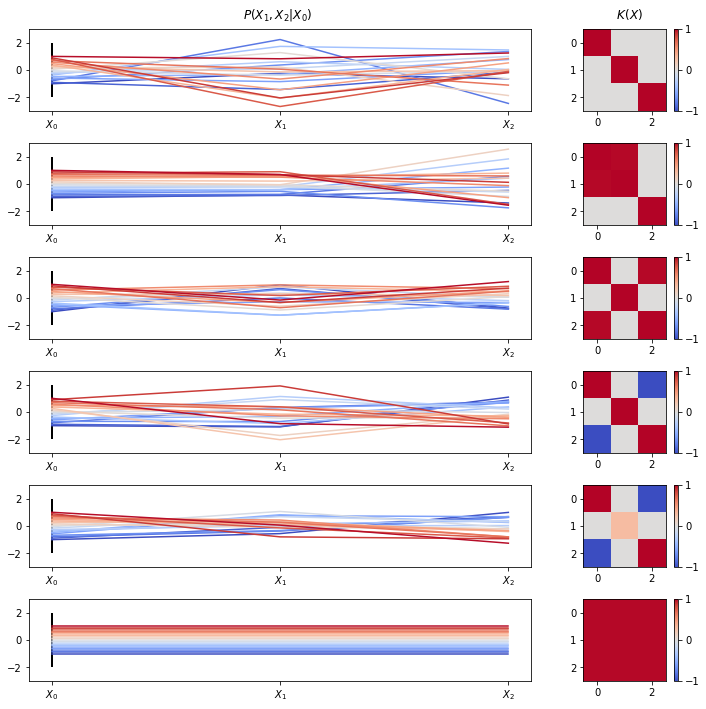

In [8]:
D = 3
mean = np.zeros(D)
cov = np.eye(D)
n_samples=20
    
fig, ax = plt.subplots(6,2, figsize=(10,10), gridspec_kw={'width_ratios': [3, 1]})
fig.suptitle('$P(X_1, X_2 | X_0$)'+' '*80+'$K(X)$', x=.62)

plot_samples(fig, ax[0], mean, cov, condOn=[0], cond='linear', n_samples=n_samples); 
cov = np.eye(D); cov[0,1] = cov[1,0] = 0.99
plot_samples(fig, ax[1], mean, cov, condOn=[0], cond='linear', n_samples=n_samples)
cov = np.eye(D); cov[0,2] = cov[2,0] = 0.99
plot_samples(fig, ax[2], mean, cov, condOn=[0], cond='linear', n_samples=n_samples)
cov = np.eye(D); cov[0,2] = cov[2,0] = -0.99
plot_samples(fig, ax[3], mean, cov, condOn=[0], cond='linear', n_samples=n_samples)
cov = np.eye(D); cov[0,2] = cov[2,0] = -0.99; cov[1,1] = 0.3
plot_samples(fig, ax[4], mean, cov, condOn=[0], cond='linear', n_samples=n_samples)
cov = np.ones((D,D))*0.99;
plot_samples(fig, ax[5], mean, cov, condOn=[0], cond='linear', n_samples=n_samples)

plt.tight_layout(rect=[0, 0, 1, 0.97])

### 20D GPs

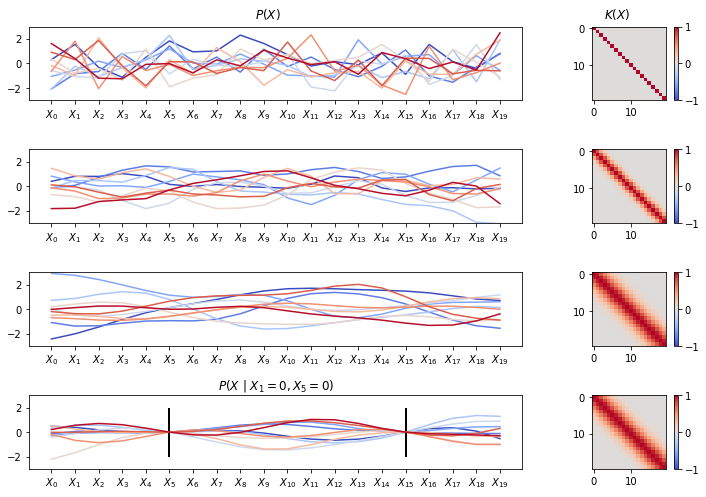

In [9]:
from sklearn.gaussian_process.kernels import RBF

D = 20
n_samples=10
mean = np.zeros(D)
    
fig, ax = plt.subplots(4,2, figsize=(10,7), gridspec_kw={'width_ratios': [3, 1]})
fig.suptitle('$P(X)$'+' '*85+'$K(X)$', x=.62)

cov = np.eye(D);
plot_samples(fig, ax[0], mean, cov, n_samples=n_samples)

kernel = RBF(length_scale=1.5)
cov = kernel(np.arange(D).reshape(-1,1))
plot_samples(fig, ax[1], mean, cov, n_samples=n_samples)

kernel = RBF(length_scale=3)
cov = kernel(np.arange(D).reshape(-1,1))
plot_samples(fig, ax[2], mean, cov, n_samples=n_samples)

kernel = RBF(length_scale=3)
cov = kernel(np.arange(D).reshape(-1,1))
plot_samples(fig, ax[3], mean, cov, condOn=[5,15], cond=[0, 0], n_samples=n_samples)
ax[3][0].set_title('$P(X~ |~ X_1=0, X_5=0)$')

plt.tight_layout(rect=[0, 0, 1, 0.97])

# Visualize poserior mean/variance

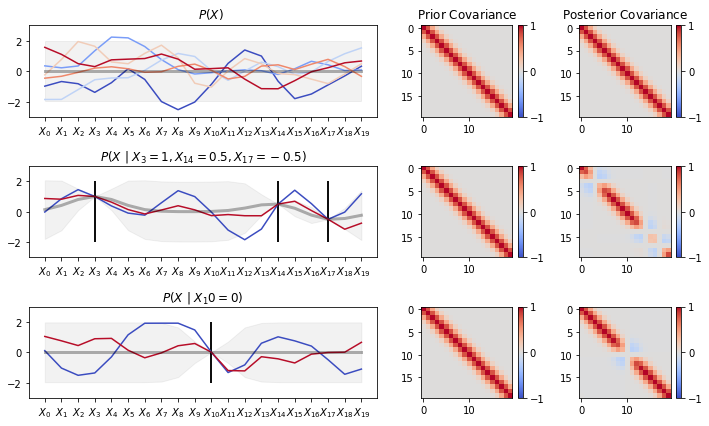

In [10]:
from sklearn.gaussian_process.kernels import RBF

np.random.seed(1)
D = 20
n_samples=2
mean = np.zeros(D)
    
fig, ax = plt.subplots(3,3, figsize=(10,6), gridspec_kw={'width_ratios': [3,1,1]})
fig.suptitle('$P(X)$'+' '*51+'Prior Covariance'+' '*12+'Posterior Covariance', x=.62)

kernel = RBF(length_scale=1.5)
cov = kernel(np.arange(D).reshape(-1,1))
pm, pcov = plot_samples(fig, ax[0], mean, cov, n_samples=6, conf=1.96)
im = ax[0][2].imshow(pcov, cmap=cm.coolwarm, vmin=-1, vmax=1)
fig.colorbar(im, ax = ax[0][2],ticks=[-1,0,1])

kernel = RBF(length_scale=1.5)
cov = kernel(np.arange(D).reshape(-1,1))
pm, pcov = plot_samples(fig, ax[1], mean, cov, condOn=[3, 14,17], cond=[1, 0.5,-0.5], n_samples=n_samples, conf=1.96)
im = ax[1][2].imshow(pcov, cmap=cm.coolwarm, vmin=-1, vmax=1)
fig.colorbar(im, ax = ax[1][2],ticks=[-1,0,1])
ax[1][0].set_title('$P(X~|~X_3=1, X_{14}=0.5, X_{17}=-0.5)$')
np.random.seed(2)
pm, pcov = plot_samples(fig, ax[2], mean, cov, condOn=[10], cond=[0], n_samples=n_samples, conf=1.96)
im = ax[2][2].imshow(pcov, cmap=cm.coolwarm, vmin=-1, vmax=1)
fig.colorbar(im, ax = ax[2][2],ticks=[-1,0,1])
ax[2][0].set_title('$P(X~|~X_10=0)$')

plt.tight_layout(rect=[0, 0, 1, 0.97])

# Jass dataset

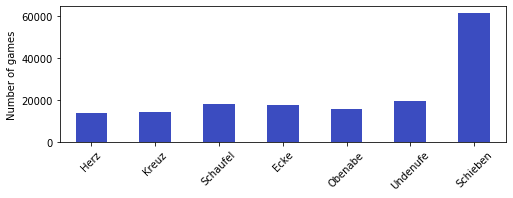

In [11]:
import numpy as np
import pandas as pd
import itertools
datafile = 'data/jass/rnd_01.csv'
col_names = [a+str(b) for (a,b) in itertools.product([farbe for farbe in 'HKSE'], [bild for bild in range(9)])]+["Geschoben", "Player", "Aktion"]
data = pd.read_csv(datafile, header=None, names=col_names)
a = data['Aktion'].value_counts().sort_index()
a.rename({i:a for i,a in enumerate(['Herz', 'Kreuz', 'Schaufel', 'Ecke', 'Obenabe', 'Undenufe', 'Schieben'])}).plot(kind='bar',color=cm.coolwarm(0),figsize=(8,2.5), rot=45)
plt.ylabel("Number of games")
plt.show()

# Kernels

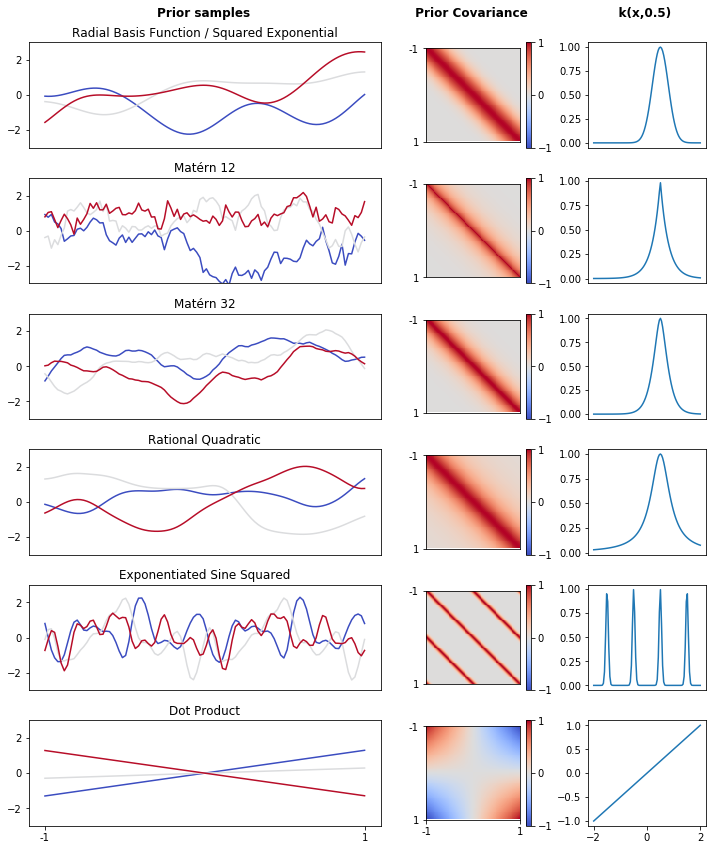

In [278]:
import sklearn.gaussian_process.kernels as kernels

np.random.seed(1)
D = 100
n_samples=2
mean = np.zeros(D)
    
ls = 0.3
ks = {
    'Radial Basis Function / Squared Exponential' : kernels.RBF(length_scale=ls),
    'Matérn 12' : kernels.Matern(length_scale=ls, nu=0.5),
    'Matérn 32' : kernels.Matern(length_scale=ls, nu=1.5),
    'Rational Quadratic' : kernels.RationalQuadratic(length_scale=ls, alpha=1),
    'Exponentiated Sine Squared' : kernels.ExpSineSquared(length_scale=ls, periodicity=1),
    'Dot Product' : kernels.DotProduct(sigma_0=0),
}

fig, ax = plt.subplots(len(ks),3, figsize=(10,2*len(ks)), gridspec_kw={'width_ratios': [3,1,1]})
fig.suptitle('Prior samples'+' '*40+'Prior Covariance'+' '*22+'k(x,0.5)', x=.58, fontweight='bold')


for i,it in enumerate(ks.items()):
    name = it[0]
    k = it[1]
    cov = k(np.linspace(-1,1,D).reshape(-1,1))
    plot_samples(fig, ax[i], mean, cov, n_samples=3)
    ax[i][0].set_xticks([0,D-1]); ax[i][0].set_xticklabels([-1,1])
    ax[i][0].set_title(name)
    ax[i][1].set_xticks([0,100]), ax[i][1].set_xticklabels([-1,1])
    ax[i][1].set_yticks([0,100]), ax[i][1].set_yticklabels([-1,1])
    ax[i][2].plot(np.linspace(-2,2,D), k(np.ones(D).reshape(-1,1)/2, np.linspace(-2,2,D).reshape(-1,1))[0])
    if i < len(ks)-1:
        ax[i][0].set_xticks([]); ax[i][1].set_xticks([]); ax[i][2].set_xticks([])


plt.tight_layout(rect=[0, 0, 1, 0.97])



## Isotropic kernels

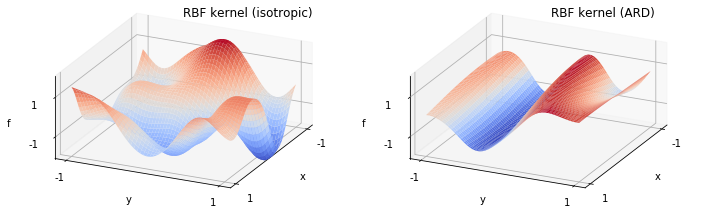

In [235]:
import GPy

np.random.seed(1)
D = 50
XY = np.meshgrid(np.linspace(-1,1,D), np.linspace(-1,1,D))
X = np.stack([XY[0].flatten(), XY[1].flatten()], 1)
fig = plt.figure(figsize=(10,3))
projection_kwargs = {'projection':'3d', 'proj_type':'ortho', 'elev':40, 'azim':25, 'xlabel':'x', 'ylabel':'y', 'zlabel':'f',  'zlim3d':(-2,2)}

# isotripic kernel
k = GPy.kern.RBF(2, variance=1.0, lengthscale=[.3], ARD=False)
m = GPy.models.GPRegression(np.array([[0,0]]), np.array([[0]]),kernel=k)
z1 = m.posterior_samples_f(X,size=1)
ax1 = fig.add_subplot('121', **projection_kwargs)
ax1.plot_surface(XY[0], XY[1], z1.reshape(D,D), cmap=cm.coolwarm)
ax1.set_xticks(np.linspace(-1,1,2)); ax1.set_xticklabels([-1]+[1])
ax1.set_yticks(np.linspace(-1,1,2)); ax1.set_yticklabels([-1]+[1])
ax1.set_zticks(np.linspace(-1,1,2)); ax1.set_zticklabels([-1]+[1])
ax1.set_title('RBF kernel (isotropic)', x=0.7)

# automatic relevance determination
k = GPy.kern.RBF(2, variance=1.0, lengthscale=[2,.3], ARD=True)
m = GPy.models.GPRegression(np.array([[0,0]]), np.array([[0]]),kernel=k)
z2 = m.posterior_samples_f(X,size=1)
ax2 = fig.add_subplot('122', **projection_kwargs)
ax2.plot_surface(XY[0], XY[1], z2.reshape(D,D), cmap=cm.coolwarm)
ax2.set_xticks(np.linspace(-1,1,2)); ax2.set_xticklabels([-1]+[1])
ax2.set_yticks(np.linspace(-1,1,2)); ax2.set_yticklabels([-1]+[1])
ax2.set_zticks(np.linspace(-1,1,2)); ax2.set_zticklabels([-1]+[1])
ax2.set_title('RBF kernel (ARD)', x=0.7)
fig.tight_layout()